Importação das Bibliotecas

In [6]:
import os
import zipfile
import shutil
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import concurrent.futures
import matplotlib.pyplot as plt

import rasterio as rs
from skimage.transform import resize

Inicialização das Variáveis que seram utilizadas dirante a execução do código

In [7]:
IMG_HEIGHT = 64  # Definir a altura das imagens
IMG_WIDTH = 64   # Definir a largura das imagens
IMG_MASK_CHANNELS = 1  # Número de canais de imagem mascara
IMG_CHANNELS = 2  # Número de canais de imagem (bandas 11 e 12)
IMG_COLOR_CHANNELS = 3  # Número de canais de imagem coloridas
TAMANHO_RECORTE = IMG_HEIGHT
NUMERO_IMAGEN = 1

Diretório das Imagens e Saídas de .CSV e DataFrame

In [8]:
# Local onde as imagens seram salvas em seu computador
path = "/home/cristiano/Imagens/"

# Treino Sentinel-2
# origem =  path + "imagens_originais/Sentinel-2/treino/"
# diretorio_imagens =  path + "imagens_originais/Sentinel-2/treino_processadas/"

# # Teste Sentinel-2
# origem = path + "imagens_originais/Sentinel-2/teste/"
# diretorio_imagens =  path + "imagens_originais/Sentinel-2/teste_processadas/"

# Teste Landsat-8
origem =  path + "imagens_originais/Landsat-8/teste/"
diretorio_imagens =  path + "/imagens_originais/Landsat-8/teste_processadas/"

Extrair as imagens para o diretório onde seram processadas e adicionando um número para diferenciar as imagens de mesmo nome.

In [9]:
# Verifica se o diretório de destino existe, caso contrário, cria-o
if not os.path.exists(diretorio_imagens):
    os.makedirs(diretorio_imagens)

# Percorre todas as pastas compactadas no diretório de origem
for pasta_compactada in os.listdir(origem):
    caminho_pasta_compactada = os.path.join(origem, pasta_compactada)

    # Verifica se o item é uma pasta compactada
    if zipfile.is_zipfile(caminho_pasta_compactada):
        # Extrai o conteúdo do arquivo compactado para uma pasta temporária
        pasta_temporaria = os.path.join(diretorio_imagens, "temp")
        with zipfile.ZipFile(caminho_pasta_compactada, 'r') as zip_ref:
            zip_ref.extractall(pasta_temporaria)

        # Percorre todas as imagens na pasta temporária
        for nome_imagem in os.listdir(pasta_temporaria):
            caminho_imagem = os.path.join(pasta_temporaria, nome_imagem)

            # Verifica se o item é um arquivo de imagem
            if os.path.isfile(caminho_imagem):
                # Define o novo nome da imagem com o número no início
                novo_nome_imagem = f"{NUMERO_IMAGEN}_{nome_imagem}"

                # Move a imagem para o diretório de destino com o novo nome
                caminho_destino_imagem = os.path.join(diretorio_imagens, novo_nome_imagem)
                shutil.move(caminho_imagem, caminho_destino_imagem)

                # Incrementa o número para a próxima imagem
                NUMERO_IMAGEN += 1

        # Remove a pasta temporária após processar todas as imagens
        shutil.rmtree(pasta_temporaria)

print("Descompactação concluída.")

Descompactação concluída.


Neste ponte é realizado a criação das máscaras, tendo como base a Imagem de Banda12 e como Limiar o valor de 180. As máscaras criadas seram identificadas com o nome Mask e seus pixel seram normalizados para que o o Pixel de fundo tenha o valor 0 e a imagem o valor 1. 

In [10]:
def modificar_nome_arquivo(nome_arquivo):
    # Remover a sequência "_(Raw)"
    nome_arquivo_modificado = nome_arquivo.replace("(Raw)", "")
    return nome_arquivo_modificado

def aplicar_limiar(imagem, limiar):
    # Converte a imagem para escala de cinza
    imagem_cinza = imagem.convert('L')

    # Converte a imagem em escala de cinza para um array NumPy
    imagem_np = np.array(imagem_cinza)

    # Binariza a imagem usando o limiar
    imagem_binarizada = np.where(imagem_np < limiar, 0, 1)

    return imagem_binarizada

def normalizar_imagem(imagem):
    # Normalizar a imagem para que o valor de 0 seja preto (0) e o valor de 1 seja branco (1)
    imagem_normalizada = imagem.astype(np.float32) / 255.0

    return imagem_normalizada

def limiar_imagens(diretorio, output_dir):
    for nome_arquivo in os.listdir(diretorio):
        if nome_arquivo.endswith("B12_(Raw).tiff") or nome_arquivo.endswith("B07_(Raw).tiff"):
            # Limpar o nome do arquivo
            nome_arquivo_limpo = modificar_nome_arquivo(nome_arquivo)

            # Carrega a imagem
            caminho_arquivo = os.path.join(diretorio, nome_arquivo)
            imagem = Image.open(caminho_arquivo)

            # Aplicar o limiar de 180
            imagem_binarizada = aplicar_limiar(imagem, 180)

            # Normalizar a imagem
            imagem_normalizada = normalizar_imagem(imagem_binarizada)

            # Obter o nome do arquivo sem a extensão
            nome_sem_extensao = os.path.splitext(nome_arquivo_limpo)[0]

            # Salvar a imagem binarizada com "_Mask" antes da extensão no diretório de saída
            nome_mask = nome_sem_extensao + "Mask.tiff"
            caminho_mask = os.path.join(output_dir, nome_mask)
            imagem_mask = Image.fromarray((imagem_normalizada * 255).astype(bool))
            imagem_mask.save(caminho_mask)

# Utiliza processamento paralelo com max threads
with concurrent.futures.ThreadPoolExecutor(max_workers=11) as executor:
    futures = [executor.submit(limiar_imagens, diretorio_imagens, diretorio_imagens)]


Recorte das imagens em 64x64 
As imagens que possuem coordenadas geográficas precisam ser recortadas de tal forma que não percam esses dados. Já as máscaras não tem essa necessidade, pois não possiem essa caracteristica. 

In [11]:
import rasterio

def recortar_imagens(diretorio, tamanho_recorte):
    global numero_imagem
    
    # Percorre todas as imagens no diretório
    for nome_arquivo in os.listdir(diretorio):
        caminho_arquivo = os.path.join(diretorio, nome_arquivo)
        
        # Verifica se a imagem contém "B12_(Raw)", "B11_(Raw)" ou "Wildfires" no nome
        if "B12_(Raw)" in nome_arquivo or "B11_(Raw)" in nome_arquivo or "Wildfires" in nome_arquivo:
            # Carrega a imagem usando o rasterio para obter os metadados
            with rasterio.open(caminho_arquivo) as img:
                # Obtém as dimensões da imagem
                altura, largura = img.height, img.width
                
                # Obtém os metadados da imagem
                metadados = img.meta
            
            # Calcula o número de recortes horizontais e verticais
            num_recortes_horizontais = largura // tamanho_recorte
            num_recortes_verticais = altura // tamanho_recorte
            
            # Realiza o recorte e salva as imagens resultantes
            for i in range(num_recortes_horizontais):
                for j in range(num_recortes_verticais):
                    # Define as coordenadas do retângulo de recorte
                    esquerda = i * tamanho_recorte
                    superior = j * tamanho_recorte
                    direita = (i + 1) * tamanho_recorte
                    inferior = (j + 1) * tamanho_recorte
                    
                    # Carrega a imagem novamente para o recorte
                    with rasterio.open(caminho_arquivo) as img:
                        # Realiza o recorte usando a função read
                        recorte = img.read(window=((superior, inferior), (esquerda, direita)))
                        transform = rasterio.windows.transform(window=((superior, inferior), (esquerda, direita)), transform=img.transform)
                    
                    # Separa o nome do arquivo e a extensão
                    nome, extensao = os.path.splitext(nome_arquivo)
                    numero = nome_arquivo.split("_")[0]
                    nome = nome[nome.index('_'):]
                    
                    # Constrói o novo nome de arquivo com o prefixo desejado
                    novo_nome_arquivo = f"{str(numero).zfill(6)}{nome}_recorte_{i}_{j}{extensao}"
                    
                    # Salva o recorte em um novo arquivo com os mesmos metadados da imagem original
                    caminho_recorte = os.path.join(diretorio, novo_nome_arquivo)
                    with rasterio.open(caminho_recorte, 'w', **metadados) as dest:
                        dest.write(recorte)
                    
                    # Incrementa o número para a próxima imagem
                    numero_imagem += 1
                    
            # Remove a imagem original
            os.remove(caminho_arquivo)
        
        # Verifica se a imagem contém "Mask" no nome
        elif "Mask" in nome_arquivo:
            # Carrega a imagem
            imagem = cv2.imread(caminho_arquivo)
            
            # Obtém as dimensões da imagem
            altura, largura, _ = imagem.shape
            
            # Calcula o número de recortes horizontais e verticais
            num_recortes_horizontais = largura // tamanho_recorte
            num_recortes_verticais = altura // tamanho_recorte
            
            # Realiza o recorte e salva as imagens resultantes
            for i in range(num_recortes_horizontais):
                for j in range(num_recortes_verticais):
                    # Define as coordenadas do retângulo de recorte
                    esquerda = i * tamanho_recorte
                    superior = j * tamanho_recorte
                    direita = (i + 1) * tamanho_recorte
                    inferior = (j + 1) * tamanho_recorte
                    
                    # Realiza o recorte
                    recorte = imagem[superior:inferior, esquerda:direita]
                    
                    # Separa o nome do arquivo e a extensão
                    nome, extensao = os.path.splitext(nome_arquivo)
                    numero = nome_arquivo.split("_")[0]
                    nome = nome[nome.index('_'):]
                    
                    # Constrói o novo nome de arquivo com o prefixo desejado
                    novo_nome_arquivo = f"{str(numero).zfill(6)}{nome}_recorte_{i}_{j}{extensao}"
                    
                    # Salva o recorte em um novo arquivo
                    caminho_recorte = os.path.join(diretorio, novo_nome_arquivo)
                    cv2.imwrite(caminho_recorte, recorte)
                    
                    # Incrementa o número para a próxima imagem
                    numero_imagem += 1
                    
            # Remove a imagem original
            os.remove(caminho_arquivo)
            
    # Libera a memória das imagens
    cv2.destroyAllWindows()

numero_imagem = 0
recortar_imagens(diretorio_imagens, TAMANHO_RECORTE)


É criado um dataframe para salvar ID_Imagem, Banda12, Linha, Coluna, Latitude e Longitude de cada imagem com o limiar maior ou igual a 180. Isso é feito para que seja possivel obter as coordenadas geográficas durante a visualização das imagens. 

In [12]:
def encontrar_coordenadas_todos_pixels_true(diretorio_imagens, limite_valor_pixel):
    # Lista para armazenar as informações de ID da imagem, nome do arquivo, linha, coluna, latitude e longitude de cada pixel true
    informacoes_pixels_true = []

    # Iterar sobre os arquivos no diretório
    for arquivo in os.listdir(diretorio_imagens):
        if "B12_(Raw)" in arquivo and arquivo.endswith(".tiff"):
            caminho_arquivo = os.path.join(diretorio_imagens, arquivo)

            # Extrair o nome do arquivo e sua extensão usando os.path.basename
            nome_arquivo = os.path.basename(caminho_arquivo)

            # Extrair o ID da imagem do nome do arquivo (assumindo que o ID está antes do primeiro "_")
            id_imagem = nome_arquivo.split("_")[0]

            # Abrir a imagem usando o rasterio
            with rs.open(caminho_arquivo) as img:
                # Ler a matriz de pixels da imagem
                matriz_pixels = img.read(1)

                # Encontrar as posições de todos os pixels true
                indices_pixels_true = np.where(matriz_pixels >= limite_valor_pixel)
                if len(indices_pixels_true[0]) > 0:
                    linhas, colunas = indices_pixels_true

                    # Obter as coordenadas de todos os pixels usando o transformador da imagem
                    transformador = img.transform
                    latitudes, longitudes = rs.transform.xy(transformador, linhas, colunas)

                    # Adicionar as informações de cada pixel true à lista
                    for linha, coluna, latitude, longitude in zip(linhas, colunas, latitudes, longitudes):
                        informacoes_pixels_true.append((id_imagem, nome_arquivo, linha, coluna, latitude, longitude))

    return informacoes_pixels_true

# Valor limite do pixel para considerá-lo como "true"
limite_valor_pixel = 180

# Encontrar as coordenadas de todos os pixels true nas imagens do diretório
lista_informacoes = encontrar_coordenadas_todos_pixels_true(diretorio_imagens, limite_valor_pixel)

# Criar um DataFrame a partir da lista de informações
df_metadados = pd.DataFrame(lista_informacoes, columns=["ID_Imagem", "Banda12", "Linha", "Coluna", "Latitude", "Longitude"])

# Ordenar o DataFrame pela coluna "ID_Imagem"
df_metadados.sort_values(by="ID_Imagem", inplace=True)

# Salvar o DataFrame em um arquivo CSV (ou outro formato de sua escolha)
destino_csv = os.path.join(diretorio_imagens, "metadados.csv")
df_metadados.to_csv(destino_csv, index= False )


Neste ponto é criado a estrutura que será a entrada para o treinamento da Rede Neural Convolucional. 

In [8]:
# Função para redimensionar as imagens de entrada para o tamanho desejado
def redimensionar_imagem(imagem, altura_desejada, largura_desejada):
    return resize(imagem, (altura_desejada, largura_desejada), mode='constant', preserve_range=True)

# Obter número de imagens de treino
NUM_TRAIN_IMAGES = len([f for f in os.listdir(diretorio_imagens) if "Mask" in f])

# Obter listas de nomes de arquivo
banda11_list = sorted([f for f in os.listdir(diretorio_imagens) if "B11_(Raw)" in f])
banda12_list = sorted([f for f in os.listdir(diretorio_imagens) if "B12_(Raw)" in f])
seg_list = sorted([f for f in os.listdir(diretorio_imagens) if "Mask" in f])
color_list = sorted([f for f in os.listdir(diretorio_imagens) if "Wildfires" in f])

with pd.option_context("display.max_columns", None):
    df = pd.DataFrame({'banda11': banda11_list, 'banda12': banda12_list, 'seg': seg_list, 'color': color_list})

# Obter listas de IDs
train_banda11_id_list = df['banda11'].tolist()
train_banda12_id_list = df['banda12'].tolist()
train_mask_id_list = df['seg'].tolist()
train_color_id_list = df['color'].tolist()

#criando as matrizes para armazenar as imagens 
# X_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)
# Z_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), dtype=np.float32)

X_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)
Z_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), dtype=np.float32)

# Iterar sobre as listas usando enumerate
for i, (banda11_id, banda12_id, mask_id, color_id) in enumerate(zip(train_banda11_id_list, train_banda12_id_list, train_mask_id_list, train_color_id_list)):
    # Construir caminhos completos
    path_banda11 = os.path.join(diretorio_imagens, banda11_id)
    path_banda12 = os.path.join(diretorio_imagens, banda12_id)
    path_seg = os.path.join(diretorio_imagens, mask_id)
    path_color = os.path.join(diretorio_imagens, color_id)

    try:
        # Ler as imagens
        with rs.open(path_banda11) as img11, rs.open(path_banda12) as img12, rs.open(path_seg) as img_seg, rs.open(path_color) as img_color:
            banda11 = img11.read(1)
            banda12 = img12.read(1)
            seg = img_seg.read(1)
            color = img_color.read(1)

        # Juntar as bandas
        bandas = np.dstack((banda11, banda12))

        # Redimensionar as bandas para o tamanho desejado
        bandas_redimensionadas = redimensionar_imagem(bandas, IMG_HEIGHT, IMG_WIDTH)

        # Transformar bandas em valores entre 0 e 255
        bandas_redimensionadas = (bandas_redimensionadas / np.max(bandas_redimensionadas)) * 255

        # Inserir a imagem em X_train/X_test
        # X_train[i] = bandas_redimensionadas
        X_test[i] = bandas_redimensionadas

        # Redimensionar a máscara para a forma (IMG_HEIGHT, IMG_WIDTH, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)

        # Inserir a máscara em X_train/Y_test
        # X_train[i] = mask
        Y_test[i] = mask

        # Inserir a imagem em Z_train/Z_test
        # Z_train[i] = resize(color, (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), mode='constant', preserve_range=True)
        Z_test[i] = resize(color, (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), mode='constant', preserve_range=True)

    except (rs.errors.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda11_id}: {e}")

# print('Shape do X_train:', X_train.shape)
# print('Shape do Y_train:', Y_train.shape)
# print('Shape do Z_train:', Z_train.shape)

print('Shape do X_test:', X_test.shape)
print('Shape do Y_test:', Y_test.shape)
print('Shape do Z_test:', Z_test.shape)


/home/cristiano/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape do X_test: (1341, 64, 64, 2)
Shape do Y_test: (1341, 64, 64, 1)
Shape do Z_test: (1341, 64, 64, 3)


Salva as entradas da Rede

In [9]:
# Salvar X_train
# X_train_file = os.path.join(diretorio_imagens, 'X_train.npy')
# np.save(X_train_file, X_train)

# # Salvar Y_train
# Y_train_file = os.path.join(diretorio_imagens, 'Y_train.npy')
# np.save(Y_train_file, Y_train)

# # Salvar Y_train
# Z_train_file = os.path.join(diretorio_imagens, 'Z_train.npy')
# np.save(Z_train_file, Z_train)

Visualização de uma imagem a partir dos arquivos salvos.

In [10]:

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
# bandas = X_train[6]
# color = Z_train[6]

# # Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
# banda11 = bandas[:, :, 0]
# banda12 = bandas[:, :, 1]
# rgb = color[:, :, 2]

# # Plotar as bandas individualmente
# plt.subplot(1, 3, 1)
# plt.imshow(banda11, cmap='gray')
# plt.title('Banda 11')

# plt.subplot(1, 3, 2)
# plt.imshow(banda12, cmap='gray')
# plt.title('Banda 12')

# plt.subplot(1, 3, 3)
# plt.imshow(rgb)
# plt.title('Color')

# plt.show()

Salva as entradas da Rede

In [11]:
# Salvar X_test
X_test_file = os.path.join(diretorio_imagens, 'X_test.npy')
np.save(X_test_file, X_test)

# Salvar Y_train
Y_test_file = os.path.join(diretorio_imagens, 'Y_test.npy')
np.save(Y_test_file, Y_test)


# Salvar Z_train
Z_test_file = os.path.join(diretorio_imagens, 'Z_test.npy')
np.save(Z_test_file, Z_test)

Visualização de uma imagem a partir dos arquivos salvos.

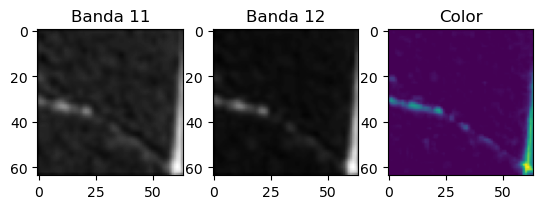

In [12]:

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
bandas = X_test[2]
color = Z_test[2]

# Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
banda11 = bandas[:, :, 0]
banda12 = bandas[:, :, 1]
rgb = color[:, :, 0]

# Plotar as bandas individualmente
plt.subplot(1, 3, 1)
plt.imshow(banda11, cmap='gray')
plt.title('Banda 11')

plt.subplot(1, 3, 2)
plt.imshow(banda12, cmap='gray')
plt.title('Banda 12')

plt.subplot(1, 3, 3)
plt.imshow(rgb)
plt.title('Color')

plt.show()

vou passar o indice e a posição do pixel e a função vai no diretório onde esta salvo as imagem e vai procurar no meta dados a longitute e a latitude da imagem.